Train set shape: (788, 15)
Test set shape: (261, 15)
Categorical features: ['Sl Geounit (Code)', 'Country Name', 'Job Group code', 'Job Type code', 'Billing Account', 'Rig Name', 'Rig type', 'Rig environment', 'Well type', 'Well Operating Environment']


[I 2024-08-19 15:29:45,547] A new study created in memory with name: no-name-586ec8c7-cdad-4477-bd0e-be16852efceb
[I 2024-08-19 15:29:53,135] Trial 0 finished with value: 790207.1593988914 and parameters: {'iterations': 62, 'learning_rate': 0.205994412387004, 'depth': 6, 'l2_leaf_reg': 0.007688944729506224, 'bootstrap_type': 'Bernoulli', 'subsample': 0.6856349229566141}. Best is trial 0 with value: 790207.1593988914.
[I 2024-08-19 15:29:56,846] Trial 1 finished with value: 768226.558593122 and parameters: {'iterations': 55, 'learning_rate': 0.11786280265199298, 'depth': 6, 'l2_leaf_reg': 7.418568200161989e-05, 'bootstrap_type': 'Bernoulli', 'subsample': 0.888414408348583}. Best is trial 1 with value: 768226.558593122.
[I 2024-08-19 15:30:11,258] Trial 2 finished with value: 791047.1815701599 and parameters: {'iterations': 92, 'learning_rate': 0.042834802733947575, 'depth': 6, 'l2_leaf_reg': 5.371294396959143e-06, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9130870865218594}. Best is 

0:	learn: 610970.3510018	test: 625812.6958090	best: 625812.6958090 (0)	total: 18.1ms	remaining: 1.79s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 546823.9268
bestIteration = 6

Shrink model to first 7 iterations.
Final Test RMSE: 546823.9355458885
Final Test R2 Score: 0.32618830873597593
Selected Features:
['Job Type code', 'Billing Account', 'Rig environment', 'Well type', 'Well Operating Environment', 'Operating Days', 'Operating_CellMonth']
Best Hyperparameters:
{'iterations': 100, 'learning_rate': 0.19091968731966763, 'depth': 4, 'l2_leaf_reg': 0.0913446265767443, 'loss_function': 'RMSE', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8484122764563651, 'cat_features': [0, 1, 2, 3, 4]}


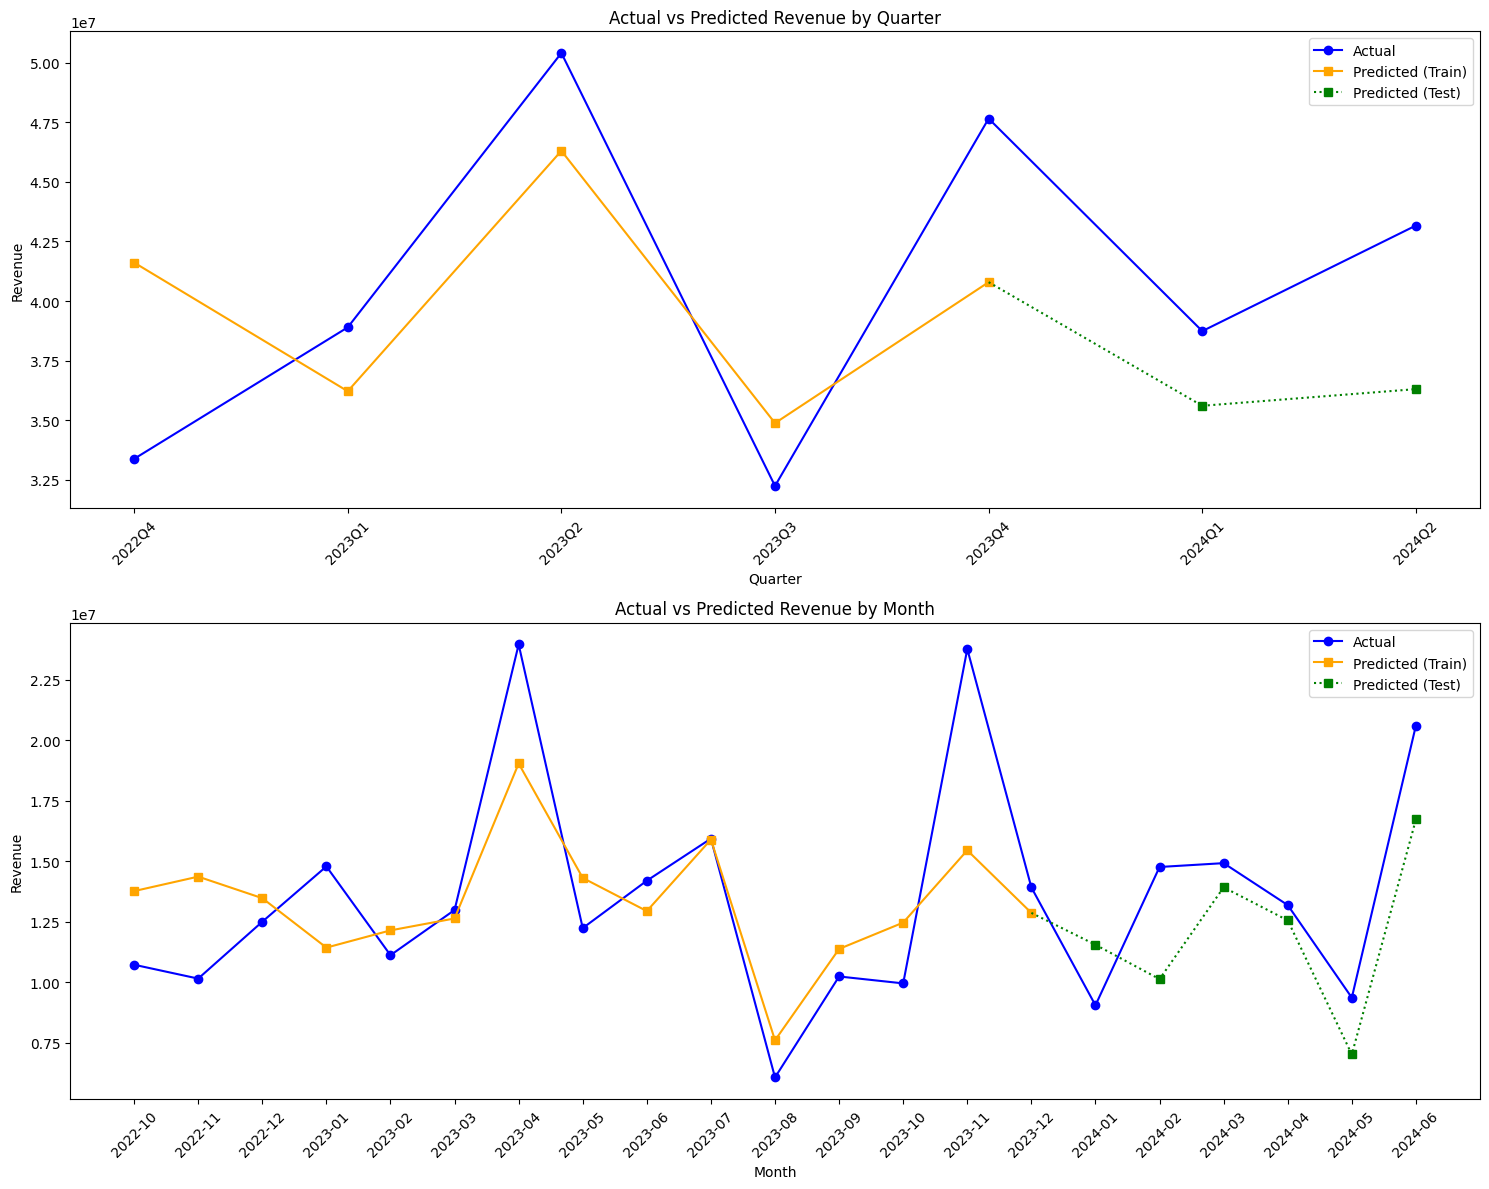

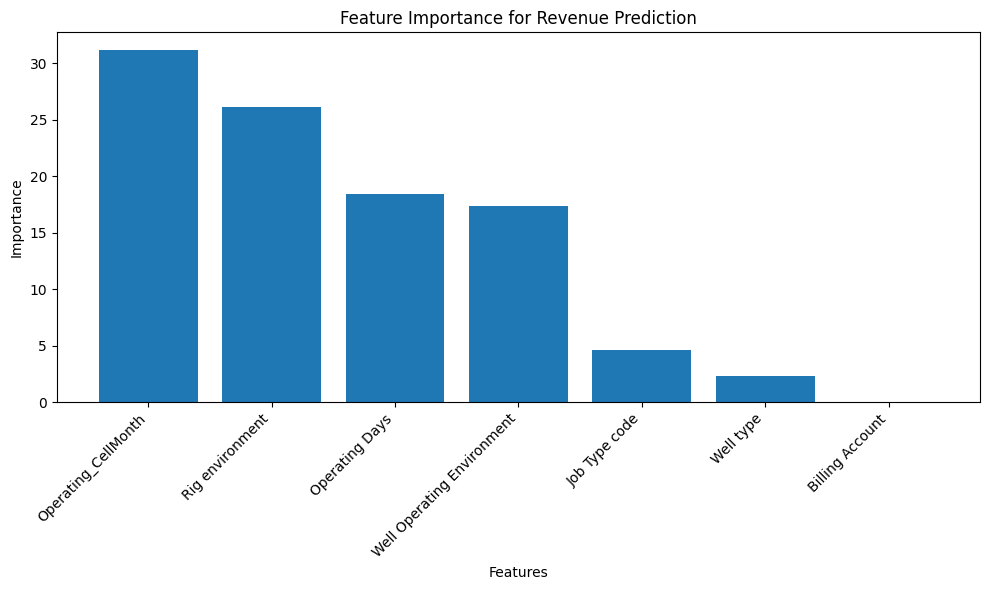

                      feature  importance
6         Operating_CellMonth   31.157851
2             Rig environment   26.144706
5              Operating Days   18.419737
4  Well Operating Environment   17.320552
0               Job Type code    4.611032
3                   Well type    2.346123
1             Billing Account    0.000000


In [4]:
# 07_complete_revenue_prediction.ipynb

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
import optuna
import joblib
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add the project root to the Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Set up matplotlib for inline plotting
%matplotlib inline

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Adjusted Date'])
    df = df.sort_values('Adjusted Date')
    
    categorical_features = ['Sl Geounit (Code)', 'Country Name', 'Job Group code', 'Job Type code', 
                            'Billing Account', 'Rig Name', 'Rig type', 'Rig environment', 'Well type', 
                            'Well Operating Environment']
    
    for feature in categorical_features:
        df[feature] = df[feature].astype('category')
    
    df['Unique_Well_Count'] = df['Unique_Well_Count'].astype(int)
    df['Tickets_Revenue'] = df['Tickets_Revenue'].astype(float)
    df['Operating Days'] = df['Operating Days'].astype(float)
    df['Operating_CellMonth'] = df['Operating_CellMonth'].astype(float)
    
    train_df = df[(df['Adjusted Date'] >= '2022-10-01') & (df['Adjusted Date'] <= '2023-12-31')]
    test_df = df[(df['Adjusted Date'] >= '2024-01-01') & (df['Adjusted Date'] <= '2024-06-30')]
    
    return train_df, test_df, categorical_features

def select_features(model, X, y, categorical_features):
    selector = SelectFromModel(model, prefit=True, threshold='median')
    feature_idx = selector.get_support()
    selected_features = X.columns[feature_idx].tolist()
    selected_cat_features = [f for f in categorical_features if f in selected_features]
    return selected_features, selected_cat_features

def objective(trial, X, y, cat_feature_indices):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 6),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1.0, log=True),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'od_type': 'Iter',
        'od_wait': 20,
        'thread_count': -1,  # Use all CPU cores
        'cat_features': cat_feature_indices
    }
    
    # Use a single train-test split instead of cross-validation
    train_size = int(0.8 * len(X))
    train_data = Pool(X[:train_size], y[:train_size], cat_features=cat_feature_indices)
    val_data = Pool(X[train_size:], y[train_size:], cat_features=cat_feature_indices)
    
    model = CatBoostRegressor(**params)
    model.fit(train_data, eval_set=val_data, early_stopping_rounds=20, verbose=0)
    
    val_preds = model.predict(X[train_size:])
    return np.sqrt(mean_squared_error(y[train_size:], val_preds))

def optimize_model(train_df, test_df, categorical_features):
    X = train_df.drop(['Adjusted Date', 'Tickets_Revenue'], axis=1)
    y = train_df['Tickets_Revenue']
    test_X = test_df.drop(['Adjusted Date', 'Tickets_Revenue'], axis=1)
    test_y = test_df['Tickets_Revenue']
    
    # Get categorical feature indices
    cat_feature_indices = [X.columns.get_loc(feature) for feature in categorical_features]
    
    # Reduce iterations for initial model
    initial_model = CatBoostRegressor(iterations=50, cat_features=cat_feature_indices)
    initial_model.fit(X, y, verbose=0)
    
    selected_features, selected_cat_features = select_features(initial_model, X, y, categorical_features)
    
    X = X[selected_features]
    test_X = test_X[selected_features]
    
    # Update cat_feature_indices for selected features
    cat_feature_indices = [X.columns.get_loc(feature) for feature in selected_cat_features]
    
    # Reduce number of trials
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective(trial, X, y, cat_feature_indices), n_trials=10)
    
    best_params = study.best_params
    best_params['cat_features'] = cat_feature_indices
    
    # Reduce iterations for final model
    best_params['iterations'] = 100
    best_model = CatBoostRegressor(**best_params)
    best_model.fit(X, y, eval_set=(test_X, test_y), early_stopping_rounds=20, verbose=50)
    
    test_preds = best_model.predict(test_X)
    final_test_rmse = np.sqrt(mean_squared_error(test_y, test_preds))
    final_test_r2 = r2_score(test_y, test_preds)
    
    return best_model, selected_features, final_test_rmse, final_test_r2

def create_revenue_plots(train_df, test_df, best_model, selected_features):
    train_df['Quarter'] = train_df['Adjusted Date'].dt.to_period('Q')
    test_df['Quarter'] = test_df['Adjusted Date'].dt.to_period('Q')
    train_df['Month'] = train_df['Adjusted Date'].dt.to_period('M')
    test_df['Month'] = test_df['Adjusted Date'].dt.to_period('M')

    X_train = train_df[selected_features]
    X_test = test_df[selected_features]

    train_df['Predicted'] = best_model.predict(X_train)
    test_df['Predicted'] = best_model.predict(X_test)

    full_df = pd.concat([train_df, test_df])

    def plot_data(data, time_period, ax):
        data['TimePeriod_str'] = data[time_period].astype(str)
        
        ax.plot(data['TimePeriod_str'], data['Tickets_Revenue'], label='Actual', marker='o', color='blue')
        
        train_periods = train_df[time_period].unique()
        test_periods = test_df[time_period].unique()
        
        train_plot = data[data[time_period].isin(train_periods)]
        test_plot = data[data[time_period].isin(test_periods)]
        
        ax.plot(train_plot['TimePeriod_str'], 
                train_plot['Predicted'], 
                label='Predicted (Train)', marker='s', color='orange')
        
        test_color = 'green'
        test_line_style = ':'
        
        ax.plot(test_plot['TimePeriod_str'], 
                test_plot['Predicted'], 
                label='Predicted (Test)', marker='s', color=test_color, linestyle=test_line_style)

        if not train_plot.empty and not test_plot.empty:
            last_train_period = train_periods[-1]
            first_test_period = test_periods[0]
            
            last_train_pred = train_plot[train_plot[time_period] == last_train_period]['Predicted'].values[0]
            first_test_pred = test_plot[test_plot[time_period] == first_test_period]['Predicted'].values[0]
            
            connecting_periods = [last_train_period, first_test_period]
            connecting_predictions = [last_train_pred, first_test_pred]
            
            ax.plot([p.strftime('%Y-%m' if time_period == 'Month' else '%YQ%q') for p in connecting_periods], 
                    connecting_predictions, 
                    linestyle=test_line_style, color=test_color)

        ax.set_title(f'Actual vs Predicted Revenue by {time_period}')
        ax.set_xlabel(time_period)
        ax.set_ylabel('Revenue')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot quarterly data
    quarterly_data = full_df.groupby('Quarter').agg({
        'Tickets_Revenue': 'sum',
        'Predicted': 'sum'
    }).reset_index()
    plot_data(quarterly_data, 'Quarter', ax1)

    # Plot monthly data
    monthly_data = full_df.groupby('Month').agg({
        'Tickets_Revenue': 'sum',
        'Predicted': 'sum'
    }).reset_index()
    plot_data(monthly_data, 'Month', ax2)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    file_path = project_root / "processed_data" / "processed_tickets_wles_ops_data.csv"
    train_df, test_df, categorical_features = load_and_preprocess_data(file_path)
    
    print("Train set shape:", train_df.shape)
    print("Test set shape:", test_df.shape)
    print("Categorical features:", categorical_features)

    best_model, selected_features, final_test_rmse, final_test_r2 = optimize_model(train_df, test_df, categorical_features)

    print(f"Final Test RMSE: {final_test_rmse}")
    print(f"Final Test R2 Score: {final_test_r2}")
    print("Selected Features:")
    print(selected_features)
    print("Best Hyperparameters:")
    print(best_model.get_params())

    # Save the best model
    joblib.dump(best_model, 'best_catboost_model_revenue.joblib')

    create_revenue_plots(train_df, test_df, best_model, selected_features)

    # Feature Importance
    feature_importance = best_model.feature_importances_
    feature_names = selected_features

    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.title('Feature Importance for Revenue Prediction')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(feature_importance_df)